In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install dill
!pip install torch
!pip install torchtext

### [모듈 불러오기]

In [36]:
import dill
import time
import random
import numpy as np
from sklearn.metrics import roc_curve, auc

import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn

from torchtext.legacy.data import Field
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import BucketIterator
from torchtext.legacy.data import Iterator
RANDOM_SEED = 2020
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DATA_PATH = "/content/drive/MyDrive/GitHub/MachineLearning/PythorchDeepLearningProject/딥러닝을 이용한 수능 영어 풀기/data/processed"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
RANDOM_SEED = 2020
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DATA_PATH = "/content/drive/MyDrive/GitHub/MachineLearning/PythorchDeepLearningProject/딥러닝을 이용한 수능 영어 풀기/data/processed"

In [20]:
print(torch.__version__)

1.10.0+cu111


### [모델 클래스 정의하기]

In [21]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, pad_idx):
        super().__init__()
        self.embed_layer = nn.Embedding(
            # 생성할 Embedding Layer의 크기를 정해줌, 보통은 단어장의 크기
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            # 자연어 처리에서 배치별로 문장의 크기를 맞추기 위해서 짧은 문장에 Padding을 붙여서 길이를 맞춤
            # 그런데 이 Padding은 특별한 의미를 갖고 있지 않음
            # 학습에서 제외하기 위해 Padding이 단어장에서 어떤 숫자를 갖고 있는지 알려줌으로써 학습되지 않게 함.
            padding_idx=pad_idx
        )
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5
        )
        self.last_layer = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            # 마지막 Output 크기를 1로 줌 (맞는지 아닌지 점수가 가장 낮은 문장이 문법적으로 맞지 않다고 판단)
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        # 이 모델은 숫자로 이루어진 토큰을 Input으로 받는다고 가정
        # 그렇기에 우선 들어온 Input 값을 Embedding 값으로 변환시켜 주어야 함
        embed_x = self.embed_layer(x)
        # LSTM은 Output, (Hidden State, Cell State)를 반환 함, 이 중 State 값들은 사용하지 않으므로 반환 받지 않음
        output, (_, _) = self.lstm_layer(embed_x)
        # LSTM의 Output은 (배치 크기, 문장 길이, Output Size)라는 Size를 갖고 있음. 가장 마지막 단어의 결과 값만 사용
        last_output = output[:, -1, :]
        # 문장의 마지막 단어의 Output을 Fully Connected Layer에 통과시켜 확률값을 계산
        last_output = self.last_layer(last_output)
        return last_output

### [모델 파이프라인 정의]

## >데이터셋 불러오기<

**파일에서 필요한 Field 선언하기**  
1 TEXT = Field(...)  
2 LABEL = Field(...)  
**데이터 불러오기**  
3 dataset = TabularDataset  
**불러온 데이터로 단어장 만들기**  
4 TEXT.build_vocab(dataset)  
**Data Loader 만들기**  
5 data_loadet = BucketIterator(dataset, ..)

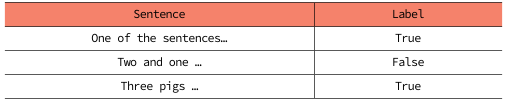  
문장은 TEXT, 정답은 LABEL로 각각의 Field를 정의

### [문장 필드 정의]

In [22]:
TEXT = Field(
    sequential=True, # 1
    use_vocab=True, # 2
    tokenize=word_tokenize, # 3
    lower=True, # 4
    batch_first=True # 5
)

1. TEXT는 문장이 들어오는 Field. Sequential=True로 설정해서 이 필드에는 문장이 들어온다는 것을 알려줌
2. 단어를 숫자로 변환시켜주는 단어장을 만들기 위해 이 필드를 이용함
3. 불러온 문장을 토크나이징 할 함수를 입력. nltk의 word_tokenize를 이용 할 것임. word_tokenize는 영어로 이루어진 문장을 토큰화시킬 때 가장 기본적으로 사용됨.
4. 대소문자를 구분할지 말지를 설정하는 부분. 따로 대명사를 처리하지 않을 것이기에 모두 소문자로 처리
5. 자연어를 처리하는 모듈별로 지원하는 데이터의 형태가 다름. 크게 다음 두가지 형태가 있음.
- (배치, 문장)
- (문장, 배치)  
이 중 첫 번째의 방식이 필요하기에 True를 줌

### [정답 필드 정의]

In [23]:
LABEL = Field(
    sequential=False, # 1
    use_vocab=False, # 2
    batch_first=True,
)

1. 앞에서는 문장이 들어오기 때문에 True를 주었지만 이 열은 정답이 있는 열이기에 False를 줌
2. 또한 이 Field에서는 따로 단어장을 생성하지 않기에 False를 줌

### [데이터 불러오기]

In [24]:
sat_train_data, sat_valid_data, sat_test_data = \
    TabularDataset.splits(
    path="/content/drive/MyDrive/GitHub/MachineLearning/PythorchDeepLearningProject/딥러닝을 이용한 수능 영어 풀기/data/processed", # 1
    train='sat_train.tsv', # 2
    validation='sat_valid.tsv',
    test = 'sat_test.tsv',
    format = 'tsv', # 3
    fields = [('text', TEXT), ('label', LABEL)], # 4
    skip_header = 1, # 5
)
TEXT.build_vocab(sat_train_data, min_freq=2) # 6

1. 데이터가 들어 있는 폴더의 경로를 입력
2. 각각 Train, Validation, Test의 파일명을 입력
3. 데이터의 파일 포맷 형태를 줍니다. 사용할 데이터는 Tap separated value의 데이터이기에 tsv를 입력
4. 앞에서 정의한 Field를 입력해주는 부분. 입력할 때 실제 데이터의 컬럼 순서로 입력해주어야함. 그리고 Field의 이름과 Field를 묶음. 예를 들어 ("text", TEXT)라면 이 데이터는 첫 번째 컬럼에 문장이 있고 그 컬럼명을 text로 하겠다는 뜻
5. 데이터의 첫 번째 열에는 원래의 컬럼명이 들어 있음. 데이터로 사용되지 않기 때문에 따로 불러오지 않도록 해야함. 그렇기에 1을 주어서 첫 번째 열을 생략하도록 함.
6. 마지막으로 불러온 데이터 중 훈련 데이터를 이용해 TEXT의 단어장을 생성함

불러온 데이터로 Data Loader를 만들어야 하는데 일반적인 Data Loader은  
랜덤하게 추출 -> 각 문장을 정해진 길이에 맞추기 -> Tensor로 변환  

정해진 길이에 맞추기 : torchtext.BucketIterator 이용

### [Data Loader 정의]

In [25]:
sat_train_iterator, sat_valid_iterator, sat_test_iterator = \
    BucketIterator.splits(
        (sat_train_data, sat_valid_data, sat_test_data),
        batch_size=8,
        device=None,
        sort=False,
)


1. 앞에서 불러온 데이터들을 묶어서 입력해줌
2. Data Loader에서 각 배치별 크기를 의미

## >학습<  
  
1. Data Loader에서 배치 불러오기
2. 배치를 모델에 넣어서 데이터 형태 맞추기
3. 배치를 모델에 넣어서 예측값 얻기
4. 정답과 예측값을 비교해서 Loss 계산하기
5. Loss를 이용해 모델 학습시키기

### [모델 학습 함수 정의]

In [26]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for batch in train_loader: # 1
        optimizer.zero_grad()
        text = batch.text
        if text.shape[0] > 1:
            label = batch.label.type(torch.FloatTensor) # 3
            text = text.to(device)
            label = label.to(device)
            output = model(text).flatten() # 4
            loss = criterion(output, label) # 5
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

train
1. 입력 받은 Data Loader를 호출해 Batch를 부르는 코드
2. Batch는 두 개의 Attribute를 갖고 있음. 앞서 데이터를 불러올 때 준 fields=[("text", TEXT), ("label", LABEL)]에서 앞의 단어들. 여기서 text는 batch의 문장, label은 Batch의 정답을 갖고 있음
3. 문장과 정답을 불러와서 필요한 데이터 형태로 변환
4. 모델에 문장을 넣어서 결과를 출력
5. 출력된 겨로가와 정답을 비교해서 Loss를 구함

### [모델 평가 함수 정의]

In [27]:
def evaluate(model, valid_loader, optimizer, criterion, device):
    model.eval() # 1
    epoch_loss = 0
    
    with torch.no_grad(): # 2
        for _, batch in enumerate(valid_loader):
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            text = text.to(device)
            label = label.to(device)
            output = model(text).flatten()
            loss = criterion(output, label)
            epoch_loss += loss.item()

    return epoch_loss / len(valid_loader)

1. Dropout과 같이 훈련과 평가의 동작이 다른 모듈들은 각 목적에 맞게 변화를 주어야 함. 여기서는 평가를 하기 위해 model.eval()를 먼저 선언
2. torch에서는 기본적으로 Forward를 할 때 자동으로 Gradient를 계산. 하지만 평가를 진행할 때는 Gradient를 계산할 필요가 없음.

### [HyperParameter 선언]

In [28]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 20

lstm_classifier = LSTMClassifier(
    num_embeddings=len(TEXT.vocab),
    embedding_dim=100,
    hidden_size=200,
    num_layers=4,
    pad_idx=PAD_IDX,
)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
_ = lstm_classifier.to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters())
bce_loss_fn = nn.BCELoss()

### [모델 학습]

In [29]:
for epoch in range(N_EPOCHS):
    train_loss = train(
        lstm_classifier,
        sat_train_iterator,
        optimizer,
        bce_loss_fn,
        device = device
    )
    valid_loss = evaluate(
        lstm_classifier,
        sat_valid_iterator,
        optimizer,
        criterion = bce_loss_fn,
        device = device
    )
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")

Epoch: 01
	Train Loss: 0.52810
	 Val. Loss: 0.75326
Epoch: 02
	Train Loss: 0.49924
	 Val. Loss: 0.56588
Epoch: 03
	Train Loss: 0.47923
	 Val. Loss: 0.54770
Epoch: 04
	Train Loss: 0.44219
	 Val. Loss: 0.54381
Epoch: 05
	Train Loss: 0.43113
	 Val. Loss: 0.54783
Epoch: 06
	Train Loss: 0.41869
	 Val. Loss: 0.55497
Epoch: 07
	Train Loss: 0.43133
	 Val. Loss: 0.55407
Epoch: 08
	Train Loss: 0.41844
	 Val. Loss: 0.53829
Epoch: 09
	Train Loss: 0.43900
	 Val. Loss: 0.54035
Epoch: 10
	Train Loss: 0.42366
	 Val. Loss: 0.53843
Epoch: 11
	Train Loss: 0.43774
	 Val. Loss: 0.54793
Epoch: 12
	Train Loss: 0.45102
	 Val. Loss: 0.53778
Epoch: 13
	Train Loss: 0.43867
	 Val. Loss: 0.54942
Epoch: 14
	Train Loss: 0.42296
	 Val. Loss: 0.56581
Epoch: 15
	Train Loss: 0.44112
	 Val. Loss: 0.55550
Epoch: 16
	Train Loss: 0.42192
	 Val. Loss: 0.54795
Epoch: 17
	Train Loss: 0.45172
	 Val. Loss: 0.54969
Epoch: 18
	Train Loss: 0.44443
	 Val. Loss: 0.55901
Epoch: 19
	Train Loss: 0.42402
	 Val. Loss: 0.54568
Epoch: 20
	T

### [모델 저장]

In [30]:
with open("baseline_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": lstm_classifier
    }
    dill.dump(model, f)

## > Test <  

모델이 얼마나 잘 맞히는지 판단하기 위해 **Area Under Receiver Operating Characteristic(AUROC)**를 이용

### [AUROC]  

Output의 크기가 2라면 모델의 성능지표로써 정확도(Accuracy)를 사용하면 됨. 하지만 Output 크기가 1일 때는 정확도가 Threshold에 의해서 변하게 됨.  
예를 들어 아래와 같은 예측값과 정답이 있다고 가정해 보겠음

![image.png](attachment:image.png)

확률이 0.5가 넘을 경우 문법적으로 맞는 문장, 넘지 않을 경우 문법적으로 틀린 문장이라고 가정. 그러면 이 모델의 예측값은 아래와 같이 바뀌게 됨

![image.png](attachment:image.png)

정확도가 66%인 모델이 됨. 그런데 확률을 0.5 대신 0.52로 변경하면 정확도가 100%인 모델이 됨.  
이처럼 Threshold에 의해 정확도가 변하기 때문에 정확도를 신뢰하기 어려움. Threshold에 의해 변하는 값을 보완하기 위한 평가 척도가 AUROC임

### [테스트 함수 정의]

In [31]:
def test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        y_real = []
        y_pred = []
        
        for batch in test_loader:
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            text = text.to(device)
            
            output = model(text).flatten().cpu()
            
            y_real += [label] # 1
            y_pred += [output]
            
        y_real = torch.cat(y_real) # 2
        y_pred = torch.cat(y_pred)
        
    fpr, tpr, _ = roc_curve(y_real, y_pred) # 3
    auroc = auc(fpr, tpr)
    
    return auroc

1. Test 결과를 보기 위해 각 Batch의 예측값을 List에 모음
2. 모인 예측값들을 합쳐줌
3. 예측값과 정답을 이용해 AUROC를 계산

### [모델 성능 확인]

In [32]:
_ = lstm_classifier.cpu()
test_auroc = test(
    lstm_classifier, # 1
    sat_test_iterator, # 2
    "cpu"
)

print(f"SAT Dataset Test AUROC: {test_auroc:.5f}")

SAT Dataset Test AUROC: 0.65385


1. 학습이 끝난 모델을 입력.
2. 수능 Test 데이터를 입력해 결과를 확인.

일반적으로 AUROC의 기준값을 0.5로 보는데, 이 0.5라는 숫자는 동전을 던지는 확률과 같음. 그런데 이 모델은 0.57로 동전을 던지는 것보다 약간 더 좋은 상태임. 성능이 낮은 이유를 생각해보면 크게 두 가지
  
1. 데이터가 부족함
2. 모델의 성능이 문제를 풀기에 부족함  

# 성능 높이기

## > 추가 데이터 이용 <

부족한 데이터 모음 -> 수능 문제는 추가적으로 구하기 어려움  
그래서 추가적인 데이터를 구하기 ㄷ위해 공개된 데이터 셋을 활용  
Corpus of Linguistically Acceptable(CoLA) 데이터셋을 이용.  
CoLa데이터셋: 문장이 주어지면 그 문장이 문법적으로 받아들일 수 있는지를 풀고자 하는 문제들  

Train 데이터에 추가해서 학습 시키면 될 것 같은데?  
데이터 크기 차이 때문에 무리, CoLA가 1:10 비율로 훨신 더 많음 -> 편향된 결과!  

따라서 이 데이터는 Pre-Trained Model에 사용하고자 함.

### [사전 학습 데이터 불러오기]

In [42]:
TEXT = Field(
    sequential=True,
    use_vocab=True,
    tokenize=word_tokenize,
    lower=True,
    batch_first=True,
)
LABEL = Field(
    sequential=False,
    use_vocab=False,
    batch_first=True,
)
cola_train_data, cola_valid_data, cola_test_data = \
    TabularDataset.splits(
        path=DATA_PATH,
        train="cola_train.tsv", # 1
        validation="cola_valid.tsv",
        test="cola_test.tsv",
        format="tsv",
        fields=[("text", TEXT), ("label", LABEL)],
        skip_header=1,
)
TEXT.build_vocab(cola_train_data, min_freq=2) # 2
cola_train_iterator, cola_valid_iterator, cola_test_iterator = \
    BucketIterator.splits(
        (cola_train_data, cola_valid_data, cola_test_data),
        batch_size=32,
        device=None,
        sort=False,
)

1. CoLA 데이터의 파일명을 입력
2. 사전 학습을 할 때 중요한 점은 사전 학습 때 이용한 모델의 단어장을 유지하는 것. 예를 들어서 A 모델에서 Hi라는 단어는 1번 토큰인데 B 모델에서는 2번 토큰이라면 같은 단어지만 토큰이 달라지기에 모델의 성능이 보장되지 않음. 그러면 사전 학습을 한 의미가 없어지게 됨. 그래서 CoLA 데이터로 만든 단어장을 계속 사용함.

### [추가 학습 데이터 불러오기]

In [43]:
sat_train_data, sat_valid_data, sat_test_data = \
    TabularDataset.splits(
        path="/content/drive/MyDrive/GitHub/MachineLearning/PythorchDeepLearningProject/딥러닝을 이용한 수능 영어 풀기/data/processed",
        train="sat_train.tsv",
        validation="sat_valid.tsv",
        test="sat_test.tsv",
        format="tsv",
        # CoLA 데이터에서 만든 Field를 이용함
        fields=[("text", TEXT), ("label", LABEL)],
        skip_header=1,
    )
sat_train_iterator, sat_valid_iterator, sat_test_iterator = \
    BucketIterator.splits(
        (sat_train_data, sat_valid_data, sat_test_data),
        batch_size=8,
        device=None,
        sort=False,
    )

### [모델 사전 학습]

In [44]:
import copy

In [45]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 20

lstm_classifier = LSTMClassifier(
    num_embeddings=len(TEXT.vocab),
    embedding_dim=100,
    hidden_size=200,
    num_layers=4,
    pad_idx=PAD_IDX,
)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
_ = lstm_classifier.to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters())
bce_loss_fn = nn.BCELoss()

for epoch in range(N_EPOCHS):
    train_loss = train(
        lstm_classifier,
        cola_train_iterator, # 1
        optimizer,
        bce_loss_fn,
        device = device
    )
    valid_loss = evaluate(
        lstm_classifier,
        cola_valid_iterator,
        optimizer,
        criterion = bce_loss_fn,
        device = device
    )
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")
    
before_tuning_lstm_classifier = copy.deepcopy(lstm_classifier) # 2

Epoch: 01
	Train Loss: 0.61746
	 Val. Loss: 0.61655
Epoch: 02
	Train Loss: 0.60973
	 Val. Loss: 0.61895
Epoch: 03
	Train Loss: 0.61121
	 Val. Loss: 0.61763
Epoch: 04
	Train Loss: 0.61313
	 Val. Loss: 0.61741
Epoch: 05
	Train Loss: 0.61068
	 Val. Loss: 0.61721
Epoch: 06
	Train Loss: 0.60957
	 Val. Loss: 0.61823
Epoch: 07
	Train Loss: 0.60979
	 Val. Loss: 0.61789
Epoch: 08
	Train Loss: 0.60860
	 Val. Loss: 1.13145
Epoch: 09
	Train Loss: 0.66196
	 Val. Loss: 0.61916
Epoch: 10
	Train Loss: 0.60897
	 Val. Loss: 0.61793
Epoch: 11
	Train Loss: 0.60954
	 Val. Loss: 0.61798
Epoch: 12
	Train Loss: 0.60748
	 Val. Loss: 0.62458
Epoch: 13
	Train Loss: 0.60966
	 Val. Loss: 0.61862
Epoch: 14
	Train Loss: 0.60858
	 Val. Loss: 0.61818
Epoch: 15
	Train Loss: 0.60917
	 Val. Loss: 0.61784
Epoch: 16
	Train Loss: 0.60822
	 Val. Loss: 0.62398
Epoch: 17
	Train Loss: 0.60888
	 Val. Loss: 0.61784
Epoch: 18
	Train Loss: 0.60896
	 Val. Loss: 0.61762
Epoch: 19
	Train Loss: 0.60826
	 Val. Loss: 0.61785
Epoch: 20
	T

1. 우선 CoLA 데이터를 이용해 모델을 학습시킴
2. 사전 학습한 모델과 추가 학습한 모델의 성능을 비교하기 뒤해 사전 학습한 모델을 따로 저장함

### [모델 추가 학습]

In [46]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    train_loss = train(
        lstm_classifier,
        sat_train_iterator, # 1
        optimizer,
        bce_loss_fn,
        device = device
    )
    valid_loss = evaluate(
        lstm_classifier,
        sat_valid_iterator,
        optimizer,
        criterion = bce_loss_fn,
        device = device
    )
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")

Epoch: 01
	Train Loss: 0.48008
	 Val. Loss: 0.54234
Epoch: 02
	Train Loss: 0.42457
	 Val. Loss: 0.54918
Epoch: 03
	Train Loss: 0.43765
	 Val. Loss: 0.57004
Epoch: 04
	Train Loss: 0.42127
	 Val. Loss: 0.55709
Epoch: 05
	Train Loss: 0.43061
	 Val. Loss: 0.54731
Epoch: 06
	Train Loss: 0.42019
	 Val. Loss: 0.54505
Epoch: 07
	Train Loss: 0.42279
	 Val. Loss: 0.55209
Epoch: 08
	Train Loss: 0.41821
	 Val. Loss: 0.53325
Epoch: 09
	Train Loss: 0.41011
	 Val. Loss: 0.53175
Epoch: 10
	Train Loss: 0.43449
	 Val. Loss: 0.52914
Epoch: 11
	Train Loss: 0.41807
	 Val. Loss: 0.53971
Epoch: 12
	Train Loss: 0.43889
	 Val. Loss: 0.53872
Epoch: 13
	Train Loss: 0.43417
	 Val. Loss: 0.54313
Epoch: 14
	Train Loss: 0.43446
	 Val. Loss: 0.55600
Epoch: 15
	Train Loss: 0.41754
	 Val. Loss: 0.55470
Epoch: 16
	Train Loss: 0.41708
	 Val. Loss: 0.53066
Epoch: 17
	Train Loss: 0.42023
	 Val. Loss: 0.52184
Epoch: 18
	Train Loss: 0.41415
	 Val. Loss: 0.52925
Epoch: 19
	Train Loss: 0.41509
	 Val. Loss: 0.52434
Epoch: 20
	T

1. 수능 데이터를 이용해 다시 모델을 학습 시킴

### [모델 성능 비교]

In [50]:
_ = before_tuning_lstm_classifier.cpu()
lstm_sat_test_auroc = test(
    before_tuning_lstm_classifier, sat_test_iterator, "cpu"
)
_ = lstm_classifier.cpu()
lstm_turned_test_auroc = test(
    lstm_classifier, sat_test_iterator, "cpu"
)
print(f"Before fine-tuning SAT Dataset Test AuROC: {lstm_sat_test_auroc:.5f}")
print(f"After fine-tuning SAT Dataset Test AuROC: {lstm_turned_test_auroc:.5f}")

Before fine-tuning SAT Dataset Test AuROC: 0.50000
After fine-tuning SAT Dataset Test AuROC: 0.80769


좀... 결과가 이상함 책과 같이 before, after 비슷하게 나와야 하는데(모델이 충분히 데이터를 학습하지 못했기 때문) before은 정확히 0.5고 전이학습후 점수가 너무 좋음

### [모델 저장]

In [48]:
with open("before_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": before_tuning_lstm_classifier
    }
    dill.dump(model, f)
    
_ = lstm_classifier.cpu()
with open("after_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": lstm_classifier
    }
    dill.dump(model, f)

## > 심화 모델 < 

앞서 사용했던 모델은 LSTM의 가장 마지막 결과만 이용했음. LSTM은 앞에 있던 정보를 뒤로 전달할 수 있기 때문에 이전 단어의 결과도 이용할 수 있음. 하지만 LSTM구조상 앞선 정보를 저장한다 해도 계속해서 뒤로 넘어가는 과정에서 정보의 손실이 일어남  

그러면 마지막 결과 만이 아닌 LSTM 전체 결과를 이용하는 것은 어떨까?  
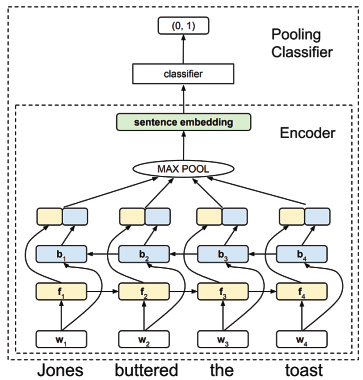  
그림은 LSTM의 전체 결과를 이용하는 모델인데. LSTM의 전체 겨로가를 사용하려면 문장의 길이를 고정해야함. 왜냐하면 Fully Connected Layer는 고정된 크기의 Input만 처리할 수 있기 때문임. 그러면 짧은 문장은 무의미한 Padding을 가지며 긴 문장은 뒷부분의 정보를 잃게 됨.  
이러한 문제를 해결하기 위해서 Max Pooling을 통해 가장 유의미한 결과만을 추출함. 그리고 유의미한 결과만 Fully Connected Layer에 통과 시켜 분류하도록 함

### [모델 정의]

In [49]:
class LSTMPoolingClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, pad_idx):
        super().__init__()
        self.embed_layer = nn.Embedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=pad_idx
        )
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5,
            batch_first=True
        )
        self.last_layer = nn.Sequential(
            nn.Linear(2 * hidden_size, 1),
            nn.Dropout(p=0.5),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embed_layer(x) # 1
        output, _ = self.lstm_layer(x) # 2
        pool = nn.functional.max_pool1d(output.transpose(1, 2), x.shape[1]) # 3
        pool = pool.transpose(1, 2).squeeze() # 4
        output = self.last_layer(pool) # 5
        return output.squeeze()

1. Token으로 들어온 데이터를 Embedding하여 값으로 변환
2. 변환된 값을 LSTM에 넣음
3. LSTM의 결과를 Max Pooling해줌.
4. Max Pooling 결과를 Fully Connected Layer에 넣기 위해 Shape를 맞춤
5. Fully Connected Layer에 넣어서 결과를 반환

### [모델 사전 학습]

In [54]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 5

lstm_pool_classifier = LSTMPoolingClassifier(
    num_embeddings=len(TEXT.vocab),
    embedding_dim=100,
    hidden_size=200,
    num_layers=4,
    pad_idx=PAD_IDX,
)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
_ = lstm_classifier.to(device)

optimizer = torch.optim.Adam(lstm_pool_classifier.parameters())
bce_loss_fn = nn.BCELoss()

for epoch in range(N_EPOCHS):
    train_loss = train(
        lstm_pool_classifier,
        cola_train_iterator, # 1
        optimizer,
        bce_loss_fn,
        device = device
    )
    valid_loss = evaluate(
        lstm_pool_classifier,
        cola_valid_iterator,
        optimizer,
        bce_loss_fn,
        device = device
    )
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")
    
before_tuning_lstm_pool_classifier = copy.deepcopy(lstm_pool_classifier) # 2

Epoch: 01
	Train Loss: 0.65311
	 Val. Loss: 0.63526
Epoch: 02
	Train Loss: 0.64995
	 Val. Loss: 0.63394
Epoch: 03
	Train Loss: 0.64476
	 Val. Loss: 0.61933
Epoch: 04
	Train Loss: 0.63588
	 Val. Loss: 0.62962
Epoch: 05
	Train Loss: 0.62622
	 Val. Loss: 0.64526


1. 모델을 CoLA 데이터를 이용해 학습시킴
2. 성능 비교를 위해 모델을 따로 저장

### [모델 추가 학습]

In [56]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_EPOCHS = 20

for epoch in range(N_EPOCHS):
    train_loss = train(
        lstm_pool_classifier, # 1
        sat_train_iterator,  # 2
        optimizer,
        bce_loss_fn,
        device = device
    )
    valid_loss = evaluate(
        lstm_pool_classifier,
        sat_valid_iterator,
        optimizer,
        criterion = bce_loss_fn,
        device = device
    )
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.5f}")
    print(f"\t Val. Loss: {valid_loss:.5f}")

Epoch: 01
	Train Loss: 0.52045
	 Val. Loss: 0.97347
Epoch: 02
	Train Loss: 0.57219
	 Val. Loss: 0.68110
Epoch: 03
	Train Loss: 0.50925
	 Val. Loss: 0.55846
Epoch: 04
	Train Loss: 0.49125
	 Val. Loss: 0.58697
Epoch: 05
	Train Loss: 0.47125
	 Val. Loss: 0.60643
Epoch: 06
	Train Loss: 0.54872
	 Val. Loss: 0.64211
Epoch: 07
	Train Loss: 0.53455
	 Val. Loss: 0.60383
Epoch: 08
	Train Loss: 0.49043
	 Val. Loss: 0.63658
Epoch: 09
	Train Loss: 0.52246
	 Val. Loss: 0.63095
Epoch: 10
	Train Loss: 0.47126
	 Val. Loss: 0.64552
Epoch: 11
	Train Loss: 0.58202
	 Val. Loss: 0.62108
Epoch: 12
	Train Loss: 0.48384
	 Val. Loss: 0.64862
Epoch: 13
	Train Loss: 0.60374
	 Val. Loss: 0.62372
Epoch: 14
	Train Loss: 0.52191
	 Val. Loss: 0.57076
Epoch: 15
	Train Loss: 0.49960
	 Val. Loss: 0.64068
Epoch: 16
	Train Loss: 0.60247
	 Val. Loss: 0.61487
Epoch: 17
	Train Loss: 0.45049
	 Val. Loss: 0.67486
Epoch: 18
	Train Loss: 0.48031
	 Val. Loss: 0.70072
Epoch: 19
	Train Loss: 0.52855
	 Val. Loss: 0.73142
Epoch: 20
	T

1. 앞서 학습한 모델을 입력함.
2. 데이터는 수능 데이터를 이용함.

### [성능 비교]

In [57]:
_ = before_tuning_lstm_pool_classifier.cpu()
_ = lstm_pool_classifier.cpu()
pool_sat_test_auroc = test(
    before_tuning_lstm_pool_classifier, sat_test_iterator, "cpu"
)
pool_turned_test_auroc = test(
    lstm_pool_classifier, sat_test_iterator, "cpu"
)
print(f"Before fine-tuning SAT Dataset Test AuROC: {pool_sat_test_auroc:.5f}")
print(f"After fine-tuning SAT Dataset Test AuROC: {pool_turned_test_auroc:.5f}")

Before fine-tuning SAT Dataset Test AuROC: 0.42308
After fine-tuning SAT Dataset Test AuROC: 0.30769


음..... 잘 모르겠다..

### [모델 저장]

In [58]:
with open("advanced_before_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": before_tuning_lstm_pool_classifier
    }
    dill.dump(model, f)
    
_ = lstm_classifier.cpu()
with open("advanced_after_tuning_model.dill", "wb") as f:
    model = {
        "TEXT": TEXT,
        "LABEL": LABEL,
        "classifier": lstm_pool_classifier
    }
    dill.dump(model, f)

# 데모

### [성능 비교 함수 정의]

In [59]:
def test(model_path):
    with open(model_path, "rb") as f: # 1
        model = dill.load(f)
        
    sat_test_data = TabularDataset( # 2
        path=f"{DATA_PATH}/sat_test.tsv",
        format="tsv",
        fields=[ # 3
            ("text", model["TEXT"]),
            ("label", model["LABEL"])
        ],
        skip_header=1
    )
    
    sat_test_iterator= BucketIterator( # 4
        sat_test_data,
        batch_size=8,
        device=None,
        sort=False,
        shuffle=False
    )
    classifier = model["classifier"] # 5
    
    with torch.no_grad():
        y_real = []
        y_pred = []
        classifier.eval()
        for batch in sat_test_iterator:
            text = batch.text
            label = batch.label.type(torch.FloatTensor)
            
            output = classifier(text).flatten().cpu()
            
            y_real += [label]
            y_pred += [output]
            
        y_real = torch.cat(y_real)
        y_pred = torch.cat(y_pred)
        
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    auroc = auc(fpr, tpr)
    
    return auroc.round(5)

1. 주어진 파일 이름으로 저장한 모델을 불러옴.
2. 수능 Test 데이터셋을 불러옴. 앞에서 Train, Validation, Test를 부를 때와는 달리 Test만을 불러옴. 이때는 path에 폴더 결로 대신 불러올 파일명을 입력
3. Field는 각 모델별로 정의한 Field를 사용.
4. 불러온 데이터로 Data Loader를 생성함.
5. 저장한 모델을 불러옴

### [성능 비교]

In [60]:
model_list = [ # 1
    "baseline_model.dill",
    "before_tuning_model.dill",
    "after_tuning_model.dill",
    "advanced_before_tuning_model.dill",
    "advanced_after_tuning_model.dill",
]

test_auroc = []
for file_name in model_list:
    model_name = file_name.replace(".dill", "") # 2
    auroc = test(file_name) # 3
    test_auroc += [(model_name, auroc)] # 4
    
test_auroc = sorted(test_auroc, key=lambda x: x[1], reverse=True) # 5
for rank, (model_name, auroc) in enumerate(test_auroc):
    print(f"Rank {rank+1} - {model_name:30} - Test AUROC: {auroc:.5f}")

Rank 1 - after_tuning_model             - Test AUROC: 0.80769
Rank 2 - baseline_model                 - Test AUROC: 0.65385
Rank 3 - before_tuning_model            - Test AUROC: 0.50000
Rank 4 - advanced_before_tuning_model   - Test AUROC: 0.42308
Rank 5 - advanced_after_tuning_model    - Test AUROC: 0.30769


1. 모델들을 저장한 파일명.
2. 파일 이름의 .dill 부분을 지우고 모델 이름으로  
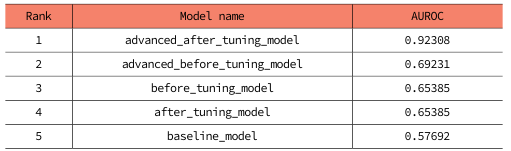  
원래 이렇게 나와야 함... 정확도가 왜 이렇게 하자가 있는지는... 잘 모르겠다.. 파이토치를 더 공부해보고 봐야 할듯

In [61]:
def predict_problem(model_path, problem):
    with open(model_path, "rb") as f:
        model = dill.load(f)
    TEXT = model["TEXT"]
    classifier = model["classifier"]
    
    problem = list(
        map(lambda x: x.replace("[", "").replace("]", ""), problem))
    tokenized_sentences = [
        word_tokenize(sentence) for sentence in problem
    ]
    sentences = []
    for tokenized_sentence in tokenized_sentences:
        sentences.append(
        [TEXT.vocab.stoi[word] for word in tokenized_sentence])
        
    with torch.no_grad():
        classifier.eval()
        predict = []
        for sentence in sentences:
            sentence = torch.LongTensor([sentence])
            predict += [classifier(sentence).item()]
    return predict

In [63]:
import pandas as pd

In [64]:
def predict_problem_with_models(model_list, problem):
    scores = {}
    for file_name in model_list:
        model_name = file_name.replace(".dill", "")
        score = predict_problem(file_name, problem)
        scores[model_name] = score
        
    score_df = pd.DataFrame(scores).T
    score_df.colums = [f"answer_{i}_score" for i in range(1, 6)]
    
    selected_answer = pd.Series(
        np.argmin(score_df.values, 1) + 1,
        index=score_df.index,
                name="selected_answer")
        
    return pd.concat([selected_answer, score_df], 1)

In [65]:
problem_1 = [
    "Competitive activities can be more than just performance showcases which the best is recognized and the rest are overlooked.",
    "The provision of timely, constructive feedback to participants on performance is an asset that some competitions and contests offer.",
    "The provision of that type of feedback can be interpreted as shifting the emphasis to demonstrating superior performance but not necessarily excellence.",
    "The emphasis on superiority is what we typically see as fostering a detrimental effect of competition.",
    "Information about performance can be very helpful, not only to the participant who does not win or place but also to those who do.",
]
problem_1_label = [0, 1, 1, 1, 1]

In [66]:
selected_answer = predict_problem_with_models(model_list, problem_1)
selected_answer = selected_answer.loc[map(lambda x:x[0], test_auroc)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [68]:
selected_answer

,selected_answer,0,1,2,3,4
after_tuning_model,1,0.754075,0.754075,0.754075,0.754075,0.754075
baseline_model,1,0.720173,0.720173,0.720173,0.720173,0.720173
before_tuning_model,1,0.659765,0.659765,0.659765,0.659765,0.659765
advanced_before_tuning_model,5,0.667697,0.673392,0.674006,0.669728,0.657545
advanced_after_tuning_model,5,0.767129,0.767037,0.766921,0.767504,0.766793


In [67]:
selected_answer

,selected_answer,0,1,2,3,4
after_tuning_model,1,0.754075,0.754075,0.754075,0.754075,0.754075
baseline_model,1,0.720173,0.720173,0.720173,0.720173,0.720173
before_tuning_model,1,0.659765,0.659765,0.659765,0.659765,0.659765
advanced_before_tuning_model,5,0.667697,0.673392,0.674006,0.669728,0.657545
advanced_after_tuning_model,5,0.767129,0.767037,0.766921,0.767504,0.766793


문제는 예측 성공